# **DSBA 6165 Applied Machine Learning**
# CNN Lab

Professor: Rick Chakra

TA: Spencer Tilley

## MNIST CNN

This code imports necessary libraries and sets up the environment for training a PyTorch model on a GPU if available

In [1]:
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import time
import numpy as np

#import helper
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# moves your model to train on your gpu if available else it uses your cpu
device = ("cuda" if torch.cuda.is_available() else "cpu")
# check GPU properties
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_properties(torch.cuda.device))

Tesla T4
_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


Now we finally download the data sets, shuffle them and transform each of them. We download the data sets and load them to DataLoader, which combines the data-set and a sampler and provides single- or multi-process iterators over the data-set.

Torchvision datasets module has many built-in datsets https://pytorch.org/vision/stable/datasets.html

In [2]:
max_degree = 25
# Define transform to normalize data
train_transform = transforms.Compose([transforms.RandomRotation(max_degree),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))
                                ])

test_transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))
                                ])

# Download and load the training data
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=test_transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 123455419.46it/s]


Extracting DATA_MNIST/MNIST/raw/train-images-idx3-ubyte.gz to DATA_MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 117152508.53it/s]


Extracting DATA_MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to DATA_MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31221717.39it/s]


Extracting DATA_MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to DATA_MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17871040.12it/s]

Extracting DATA_MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to DATA_MNIST/MNIST/raw



Once this cell is executed, our dataset is downloaded and stored in the variable train_set and test_set. In order to load the MNIST dataset in a handy way, we will need DataLoaders for the dataset. We will use a batch_size of 64 for the training.

The values 0.1307 and 0.3081 used for transforms.Normalize() transformation represents the global mean and standard deviation of the MNIST dataset and transforms.ToTensor()converts the entire array into torch tensor and divides by 255. So values are between 0.0f and 1.0f.

In [3]:
training_data = enumerate(trainloader)

In [4]:
batch_idx, (images, labels) = next(training_data)
print(type(images)) # Checking the datatype
print(batch_idx) # batch id
print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

<class 'torch.Tensor'>
0
torch.Size([64, 1, 28, 28])
torch.Size([64])


Now, let’s turn our trainloader object into an iterator with iter so we may access our images and labels from this generator. We can see the shape as (64 x 1 x 28 x 28). This means:

* 64: Represents 64 images (batch)
* 1 : One color channel ==>> Grayscale
* 28 by 28 pixel: the shape of these images so we can visualize it.

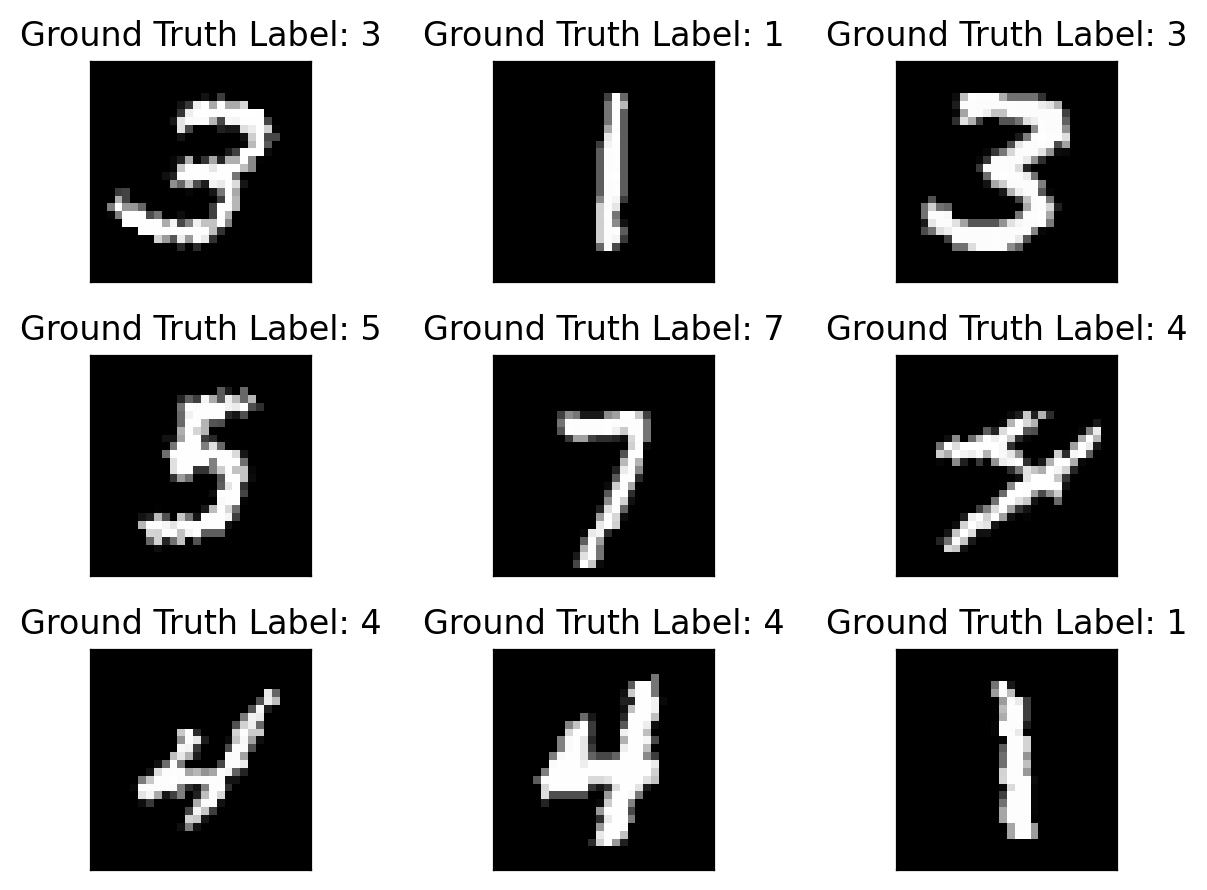

In [5]:
fig = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(images[i][0], cmap='gray') # try cmap='inferno'
    plt.title("Ground Truth Label: {}".format(labels[i]))
    plt.yticks([])
    plt.xticks([])

Now let’s build our network using this object-oriented class method within nn.module. We will use 2 fully convolutional layers, Relu activation function and MaxPooling. This will also be coupled along with 2 linear layers with a dropout probability of 0.2 per cent.

In [6]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        # Convolutional Neural Network Layer
        self.convolutaional_neural_network_layers = nn.Sequential(
                # Here we are defining our 2D convolutional layers
                # We can calculate the output size of each convolutional layer using the following formula
                # outputOfEachConvLayer = [(in_height + 2*padding - kernel_size) / stride] + 1
                # We have in_channels=1 because our input is a grayscale image
                nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                # After the first convolutional layer the output of this layer is:
                # [(28 + 2*1 - 3)/1] + 1 = 28.
                nn.MaxPool2d(kernel_size=2),
                # Since we applied maxpooling with kernel_size=2 we have to divide by 2, so we get
                # 28 / 2 = 14

                # output of our second conv layer
                nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                # After the second convolutional layer the output of this layer is:
                # [(14 + 2*1 - 3)/1] + 1 = 14.
                nn.MaxPool2d(kernel_size=2)
                # Since we applied maxpooling with kernel_size=2 we have to divide by 2, so we get
                # 14 / 2 = 7
        )

        # Linear layer
        self.linear_layers = nn.Sequential(
                # We have the output_channel=24 of our second conv layer, and 7*7 is derived by the formula
                # which is the output of each convolutional layer
                nn.Linear(in_features=24*7*7, out_features=64),
                nn.ReLU(),
                nn.Dropout(p=0.2), # Dropout with probability of 0.2 to avoid overfitting
                nn.Linear(in_features=64, out_features=10) # The output is 10 which should match the size of our class
        )

    # Defining the forward pass
    def forward(self, x):
        x = self.convolutaional_neural_network_layers(x)
        # After we get the output of our convolutional layer we must flatten it or rearrange the output into a vector
        x = x.view(x.size(0), -1)
        # Then pass it through the linear layer
        x = self.linear_layers(x)
        return x

The forward() pass defines the way our output is being computed. The line x.view(x.size(0), -1) flattens the output from the convolution layer into a vector. Most of the time when experimenting with more complex models it is advised-able to print out the tensor values for easier debugging.

Now by initializing our network the term model.to(device) sends the network we created into Cuda. Note: This only happens if you have a GPU. This helps to decrease the time it takes our network to train, then we define the optimizers we will use.

In [7]:
model = Network()
model.to(device)

Network(
  (convolutaional_neural_network_layers): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1176, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [8]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

After the forward pass, a loss function is calculated from the target output and the prediction labels in order to update weights for the best model selection in the further step. Setting up the loss function is a fairly simple step in PyTorch. Here, we will use the Cross–entropy loss, or log loss, which measures the performance of a classification model whose output is a probability value between 0 and 1. We should note that the Cross–entropy loss increases as the predicted probability diverges from the actual label.

Next, we will use Stochastic Gradient Descent optimizer for the update of hyper-parameters model.parameters() will provide the learnable parameters to the optimizer and lr=0.01 defines the learning rates for the parameter updates.

## 4. Training and Testing the Model

Our model is now ready to train. We begin by setting up an epoch size. Epoch is a single pass through the whole training dataset. In the example below, the epoch size is set to 10, meaning there will be 10 single passes of the training and weight updates.

In [9]:
print('Starting Training')
epochs = 10 # The total number of epochs

train_losses = []
test_losses = []

t0 = time.time()

for epoch in range(epochs):
    t1 = time.time()
    # prep model for training
    model.train()
    train_loss = 0

    for idx, (images, labels) in enumerate(trainloader):

        # Send these >>> To GPU
        images = images.to(device)
        labels = labels.to(device)

        # Training pass
        optimizer.zero_grad()

        # Forward pass
        output = model(images)
        loss = criterion(output, labels)

        #Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # prep model for evaluation
    model.eval()
    test_loss = 0
    accuracy = 0

    # Turn off the gradients when performing validation.
    # If we don't turn it off, we will comprise our networks weight entirely
    with torch.no_grad():
        for images, labels in testloader:

            images = images.to(device)
            labels = labels.to(device)

            log_probabilities = model(images)
            test_loss += criterion(log_probabilities, labels)

            probabilities = torch.exp(log_probabilities)
            top_prob, top_class = probabilities.topk(1, dim=1)
            predictions = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(predictions.type(torch.FloatTensor))

    train_losses.append(train_loss/len(trainloader))
    writer.add_scalar('training loss', train_loss/len(trainloader), epoch+1)
    test_losses.append((test_loss/len(testloader)).cpu().numpy())
    writer.add_scalar('testing loss', (test_loss/len(testloader)).cpu().numpy(), epoch+1)

    print("Epoch: {}/{}  ".format(epoch+1, epochs),
          "Training loss: {:.4f}  ".format(train_loss/len(trainloader)),
          "Testing loss: {:.4f}  ".format(test_loss/len(testloader)),
          "Test accuracy: {:.4f}  ".format(accuracy/len(testloader)),
          "Epoch time: {:.4f}  ".format(time.time() - t1))

print("Training Complete")
print("Total Elapsed Time: {:.4f} ".format(time.time() - t0))
writer.flush()

Starting Training
Epoch: 1/10   Training loss: 0.9132   Testing loss: 0.2811   Test accuracy: 0.9153   Epoch time: 29.5134  
Epoch: 2/10   Training loss: 0.3666   Testing loss: 0.1633   Test accuracy: 0.9468   Epoch time: 24.6453  
Epoch: 3/10   Training loss: 0.2602   Testing loss: 0.1218   Test accuracy: 0.9632   Epoch time: 22.2699  
Epoch: 4/10   Training loss: 0.2092   Testing loss: 0.0988   Test accuracy: 0.9688   Epoch time: 22.9567  
Epoch: 5/10   Training loss: 0.1810   Testing loss: 0.0912   Test accuracy: 0.9701   Epoch time: 22.0666  
Epoch: 6/10   Training loss: 0.1580   Testing loss: 0.0867   Test accuracy: 0.9705   Epoch time: 21.7307  
Epoch: 7/10   Training loss: 0.1450   Testing loss: 0.0726   Test accuracy: 0.9762   Epoch time: 22.0995  
Epoch: 8/10   Training loss: 0.1336   Testing loss: 0.0681   Test accuracy: 0.9772   Epoch time: 22.3887  
Epoch: 9/10   Training loss: 0.1270   Testing loss: 0.0624   Test accuracy: 0.9787   Epoch time: 22.9081  
Epoch: 10/10   Trai

After the forward pass and the loss, computation is done, we do a backward pass, which refers to the process of learning and updating the weights. We first need to set our gradient to zero: optimizer.zero_grad(). This is because every time a variable is backpropagated through the network multiple times, the gradient will be accumulated instead of being replaced from the previous training step in our current training step. Which will prevent our network from learning properly. Then we run a backward pass by loss.backward() and optimizer.step() which updates our parameters based on the current gradient.

By training our network we may also test our model to see how it’s performing after each epoch. The most crucial method is to set model.eval() when you want to test your network to avoid updating the gradient during testing and when you want to start training, set model.train(), so your weights may be updated.

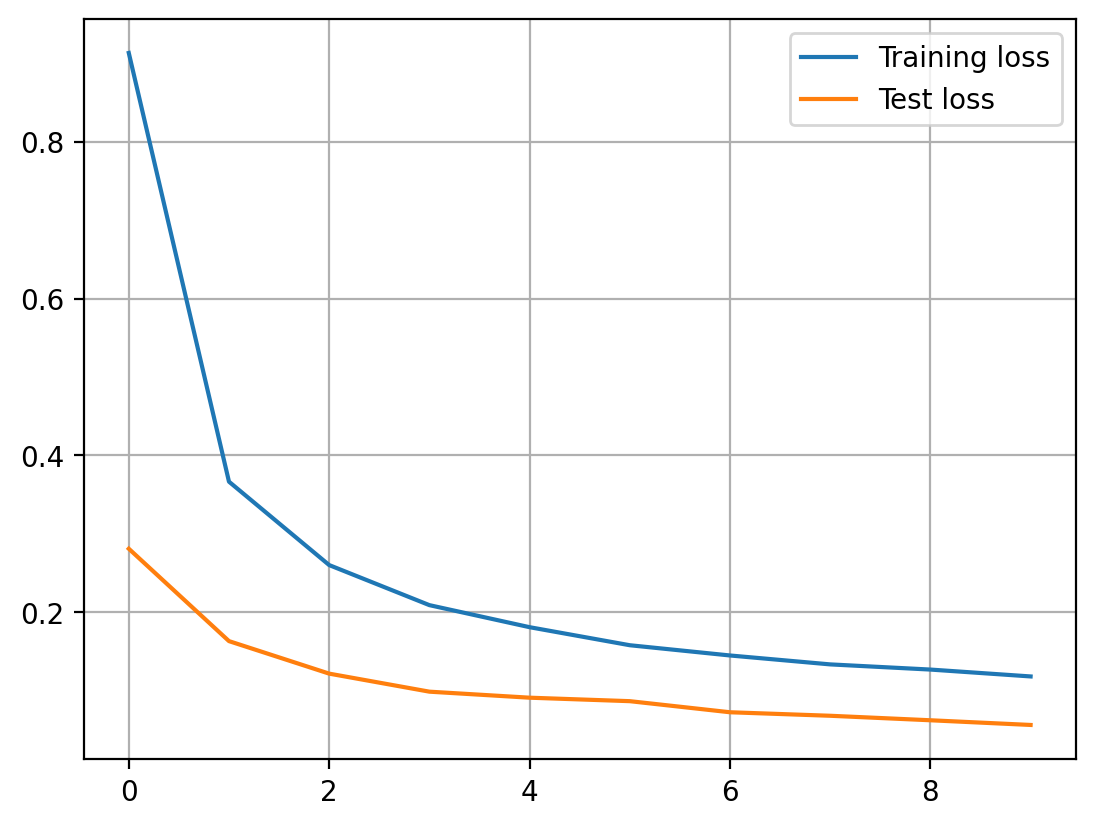

In [10]:

# plot the training and test losses
plt.plot(train_losses, label='Training loss')
plt.plot(np.array([test_loss for test_loss in test_losses]), label='Test loss')
plt.legend()
plt.grid()
plt.show()

Let’s check our training and validation accuracy. It is as simple as the code for plotting the loss.

## 5. Evaluating the Network

In [11]:
# select index of image to test
img = images[11]
img = img.to(device)
img = img.view(-1, 1, 28, 28)
print(img.shape)

# Since we want to use the already pretrained weights to make some prediction
# we are turning off the gradients
with torch.no_grad():
    logits = model(img)

torch.Size([1, 1, 28, 28])


And by passing these logits through a softmax function we get probabilities values as our output. Let’s visualize this.

[1.7144952e-11 2.3797588e-08 2.3696346e-07 1.5543771e-08 9.9996638e-01
 4.2872621e-09 5.8272104e-10 3.0348740e-06 2.2848486e-05 7.4020513e-06]


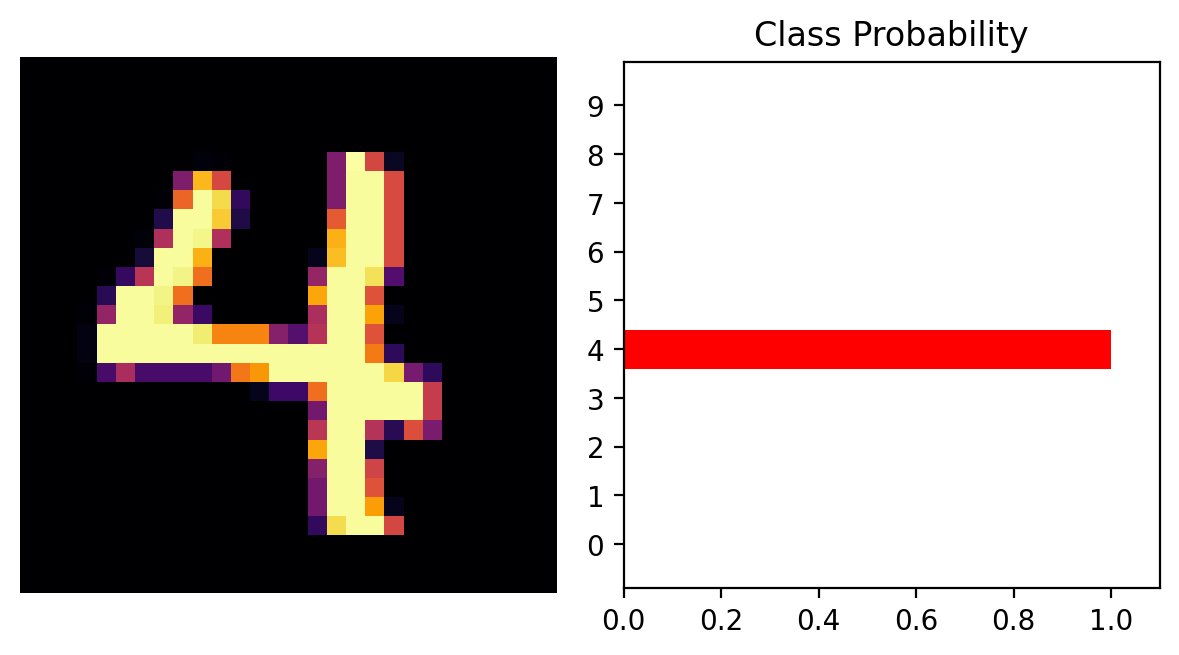

In [12]:
#We take the softmax for probabilites since our outputs are logits
probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze(), cmap='inferno')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()

We can see the input image 7 matches the probability with the highest value in the probability class figure.

Summary
To sum it up, the training pass consists of four different steps. Which are:

* First, make a forward pass through the network.
* Use the network output to calculate the loss.
* Perform a backward pass through the network with loss.backwards() and this calculates the gradients.
* Then we make a step with our optimizer which updates the weights.

Now we have learned how to train and test our model to make accurate predictions for the digit dataset. In the next tutorial we will experiment more on different datasets.

In [16]:
from torch.utils import tensorboard
%reload_ext tensorboard
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 7408), started 0:00:50 ago. (Use '!kill 7408' to kill it.)

<IPython.core.display.Javascript object>

## References
- [Building RNNs is Fun with PyTorch and Google Colab](https://colab.research.google.com/drive/1NVuWLZ0cuXPAtwV4Fs2KZ2MNla0dBUas)
- [CNN Basics with PyTorch by Sebastian Raschka](https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-basic.ipynb)
- [Tensorflow 2.0 Quickstart for experts](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/advanced.ipynb#scrollTo=DUNzJc4jTj6G)